In [17]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt

import sys
sys.path.append('../..')
from funcs.stats import get_stats

In [2]:
fps = list(Path('/Users/rdcrlzh1/Documents/uavsar-coherence/uavsar').glob('*_v2.nc'))
# fps = [fp for fp in fps if 'lowman' not in fp.stem]
dss = {fp.stem.replace('_v2',''): xr.open_dataset(fp) for fp in fps}

fig_dir = Path('/Users/rdcrlzh1/Documents/uavsar-coherence/figures/model')

In [3]:
for stem, ds in dss.items():
    for var in ['model_sd', 'model_melt', 'model_swe']:
        sub_fig_dir = fig_dir.joinpath(var)
        sub_fig_dir.mkdir(exist_ok = True)
        if sub_fig_dir.joinpath(f'{stem}_{var}.png').exists(): continue

        ds[var].mean('model_time').plot()
        plt.gca().set_title(stem)
        plt.savefig(sub_fig_dir.joinpath(f'{stem}_{var}.png'))
        plt.close()


In [4]:
lidar = []
model = []
for stem, ds in dss.items():
    if 'sd' not in ds.data_vars: continue
    sub_fig_dir = fig_dir.joinpath('lidar_model_sd')
    sub_fig_dir.mkdir(exist_ok = True)
    for time in ds['sd'].time.values:
        fig, axes= plt.subplots(2, 1, figsize = (12, 8))
        ds['model_sd'].sel(model_time = time).where(~ds['sd'].sel(time = time).isnull()).dropna('x', how = 'all').dropna('y', how = 'all').plot(ax = axes[0], vmin = 0, vmax = 2, cbar_kwargs = {'label':''})
        ds['sd'].sel(time = time).dropna('x', how = 'all').dropna('y', how = 'all').plot(ax = axes[1], vmin = 0, vmax = 2, cbar_kwargs = {'label':''})
        
        model.extend(ds['model_sd'].sel(model_time = time).where(~ds['sd'].sel(time = time).isnull()).dropna('x', how = 'all').dropna('y', how = 'all').values.ravel())
        lidar.extend(ds['sd'].sel(time = time).dropna('x', how = 'all').dropna('y', how = 'all').values.ravel())
        
        axes[0].set_title('Model Snow Depth')
        axes[1].set_title('Lidar Snow Depth')
        plt.tight_layout()
        plt.savefig(sub_fig_dir.joinpath(f'{stem}_{pd.to_datetime(time).date()}' ))
        plt.close()

<class 'list'>
<class 'numpy.ndarray'>


Text(0.01, 0.99, 'r = 0.41. rmse = 0.82m\nn = 6.25e+05')

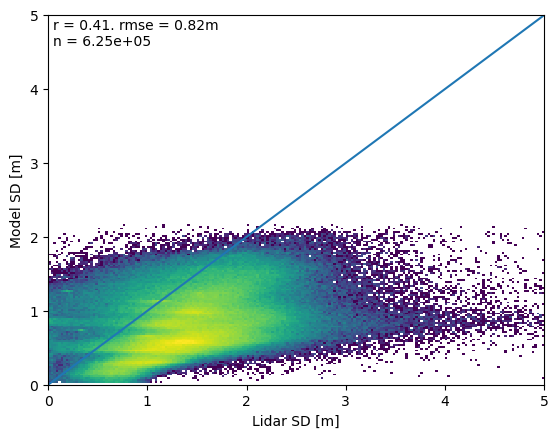

In [18]:
plt.hist2d(lidar, model, bins = 200, range=[[0,5],[0,5]], norm=mpl.colors.LogNorm())
plt.plot([0, 5], [0,5])
plt.xlabel('Lidar SD [m]')
plt.ylabel('Model SD [m]')
rmse, r, n = get_stats(lidar, model)
plt.text(0.01, 0.99, f'r = {r:.2f}. rmse = {rmse:.2f}m\nn = {n:.2e}', transform = plt.gca().transAxes, ha = 'left', va = 'top')